In [42]:
# Importing all neccessary libraries
from model import ResNetCustom, BasicBlock
from mytools import count_class_distribution, plot_class_distribution

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt



In [32]:
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("MPS is available, using MPS.")
else:
    DEVICE = torch.device("cpu")
    print("MPS is not available, using CPU.")

MPS is available, using MPS.


In [33]:
# Initiating the model with specified architecture.
def MyResNet():
    return ResNetCustom(BasicBlock, [2, 4, 4, 2], num_classes=100)

In [34]:
#Data Transformation

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

#Getting the data
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

num_train = len(train_dataset)
num_val = int(0.1 * num_train)
num_train = num_train - num_val

train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

#Using dataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
validation_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


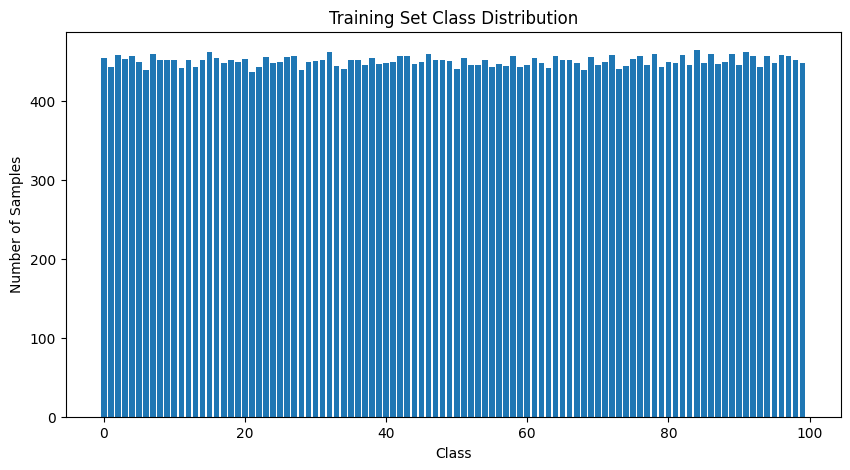

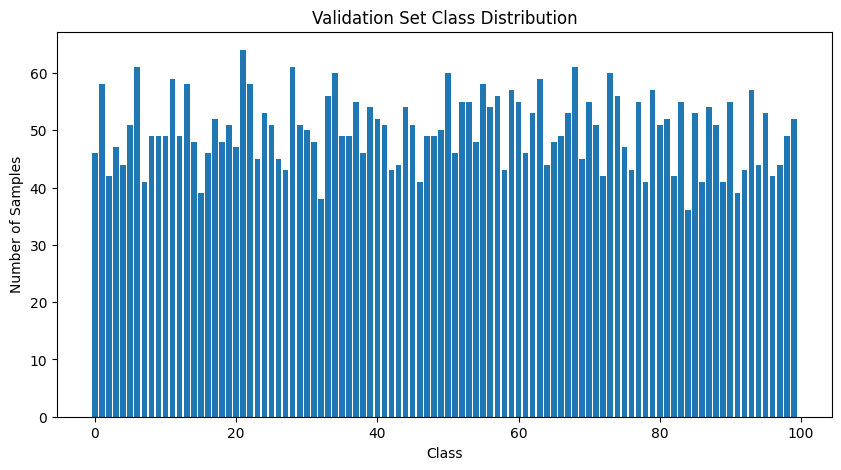

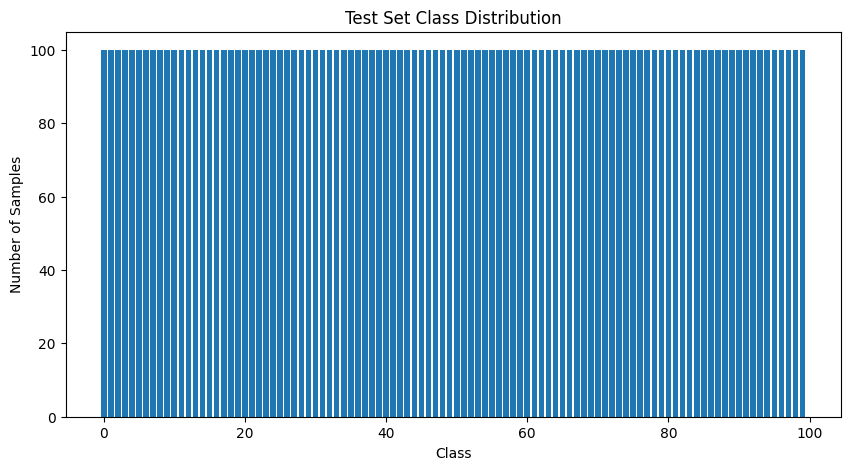

In [28]:
train_class_distribution = count_class_distribution(train_loader)
val_class_distribution = count_class_distribution(validation_loader)
test_class_distribution = count_class_distribution(test_loader)

plot_class_distribution(train_class_distribution, 'Training Set Class Distribution')
plot_class_distribution(val_class_distribution, 'Validation Set Class Distribution')
plot_class_distribution(test_class_distribution, 'Test Set Class Distribution')

In [38]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Optional: Print progress every 100 batches
        # if i % 100 == 0:
        #     print(f"Epoch {epoch}, Batch {i}, Loss: {running_loss / (i+1):.3f}, Accuracy: {100.*correct/total:.3f}%")
    
    return running_loss / len(train_loader), 100.*correct/total


def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [39]:
best_val_acc = 0
best_lr = 0
best_wd = 0
best_model = None
num_epochs = 100
models = {}
i = 0

for lr in [0.001, 0.01, 0.1]:
    for wd in [1e-4, 5e-4, 1e-3]:
        
        model = MyResNet().to(DEVICE)
        list_train_loss, list_train_acc, list_val_loss, list_val_acc = [], [], [], []

        criterion = torch.nn.CrossEntropyLoss()  # Assuming you have not applied softmax in the model

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

        print(f"Training with lr={lr} and weight_decay={wd}")
        
        for epoch in range(num_epochs):
            train_loss, train_acc = train(model, train_loader, criterion, optimizer)
            val_loss, val_acc = validate(model, validation_loader, criterion)

            print(f"For Epoch: {epoch} ---> Train Accuracy = {train_acc:.2f}%, Train Loss = {train_loss:.2f}, Validation Loss = {val_loss:.2f}, Validation Accuracy = {val_acc:.2f}%")

            list_train_acc.append(train_acc)
            list_train_loss.append(train_loss)
            list_val_acc.append(val_acc)
            list_val_loss.append(val_loss)

            if epoch % 10 == 0:
                print("LR step up")
                scheduler.step()
        
        models[i] = [list_train_acc, list_train_loss, list_val_acc, list_val_loss]
        i += 1
            
        if val_acc > best_val_acc:
            best_val_acc, best_lr, best_wd = val_acc, lr, wd
            best_model = model.state_dict()

print(f"Best model with lr={best_lr} and wd={best_wd}. Validation accuracy: {best_val_acc:.2f}%")

# Save the best model
torch.save(best_model, 'best_resnet_model.pth')


Training with lr=0.001 and weight_decay=0.0001
For Epoch: 0 ---> Train Accuracy = 7.45%, Train Loss = 4.11, Validation Loss = 3.76, Validation Accuracy = 12.08%
LR step up
For Epoch: 1 ---> Train Accuracy = 16.54%, Train Loss = 3.49, Validation Loss = 3.31, Validation Accuracy = 18.86%
For Epoch: 2 ---> Train Accuracy = 25.17%, Train Loss = 3.00, Validation Loss = 3.12, Validation Accuracy = 24.44%
For Epoch: 3 ---> Train Accuracy = 32.06%, Train Loss = 2.64, Validation Loss = 2.63, Validation Accuracy = 33.38%
For Epoch: 4 ---> Train Accuracy = 37.46%, Train Loss = 2.38, Validation Loss = 2.55, Validation Accuracy = 34.56%
For Epoch: 5 ---> Train Accuracy = 42.29%, Train Loss = 2.16, Validation Loss = 2.25, Validation Accuracy = 41.36%
For Epoch: 6 ---> Train Accuracy = 46.35%, Train Loss = 1.99, Validation Loss = 2.12, Validation Accuracy = 44.32%
For Epoch: 7 ---> Train Accuracy = 49.38%, Train Loss = 1.85, Validation Loss = 1.97, Validation Accuracy = 47.18%
For Epoch: 8 ---> Train

KeyboardInterrupt: 

In [52]:
print(f"Best model with lr={best_lr} and wd={best_wd}. Validation accuracy: {best_val_acc:.2f}%")

# Save the best model
torch.save(best_model, 'best_resnet_model.pth')

Best model with lr=0.001 and wd=0.0001. Validation accuracy: 62.72%


In [67]:
def plot_metrics(history):
    epochs = range(1, 974 + 1)
    plt.figure(figsize=(12, 5))
    plt.title("Comparing all the model configurations in a single graph")
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    #plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    #plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

In [60]:
len(models[0][1])

974

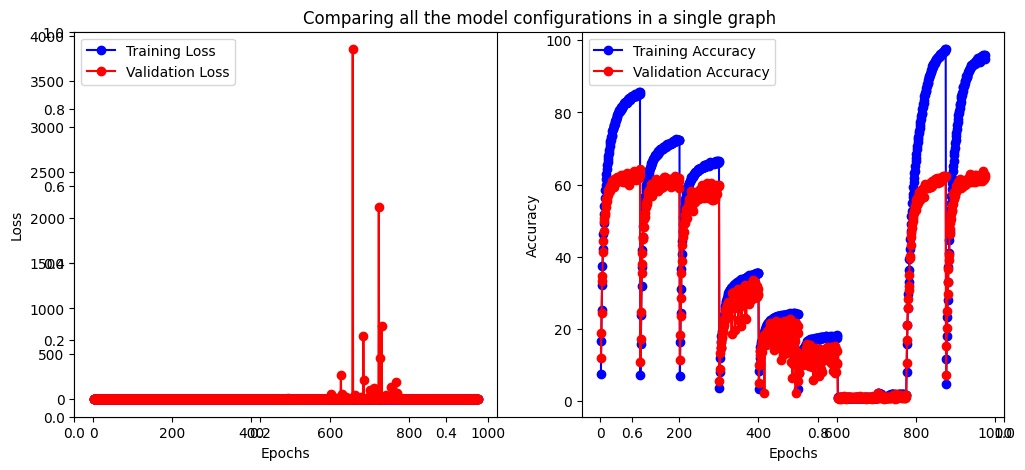

In [68]:

history = {
    'train_loss': models[0][1],
    'val_loss': models[0][3],
    'train_acc': models[0][0],
    'val_acc': models[0][2],
}

plot_metrics(history)



In [54]:

num_epochs = 100
models1 = {}
i = 0

for lr in [0.001, 0.01]:

    model = MyResNet().to(DEVICE)
    criterion = torch.nn.CrossEntropyLoss()  # Assuming you have not applied softmax in the model

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    print(f"Training with lr={lr} and weight_decay= 1e-4")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, validation_loader, criterion)

        print(f"For Epoch: {epoch} ---> Train Accuracy = {train_acc:.2f}%, Train Loss = {train_loss:.2f}, Validation Loss = {val_loss:.2f}, Validation Accuracy = {val_acc:.2f}%")

        list_train_acc.append(train_acc)
        list_train_loss.append(train_loss)
        list_val_acc.append(val_acc)
        list_val_loss.append(val_loss)

        if epoch % 10 == 0:
            print("LR step up")
            scheduler.step()
        
        models1[i] = [list_train_acc, list_train_loss, list_val_acc, list_val_loss]
        i += 1
            


Training with lr=0.001 and weight_decay= 1e-4
For Epoch: 0 ---> Train Accuracy = 8.01%, Train Loss = 4.11, Validation Loss = 4.00, Validation Accuracy = 10.62%
LR step up
For Epoch: 1 ---> Train Accuracy = 15.74%, Train Loss = 3.55, Validation Loss = 3.47, Validation Accuracy = 16.96%
For Epoch: 2 ---> Train Accuracy = 21.09%, Train Loss = 3.24, Validation Loss = 3.25, Validation Accuracy = 21.08%
For Epoch: 3 ---> Train Accuracy = 25.81%, Train Loss = 3.00, Validation Loss = 3.01, Validation Accuracy = 25.90%
For Epoch: 4 ---> Train Accuracy = 29.61%, Train Loss = 2.79, Validation Loss = 2.92, Validation Accuracy = 28.28%
For Epoch: 5 ---> Train Accuracy = 33.05%, Train Loss = 2.62, Validation Loss = 2.72, Validation Accuracy = 31.94%
For Epoch: 6 ---> Train Accuracy = 36.40%, Train Loss = 2.45, Validation Loss = 2.80, Validation Accuracy = 30.72%
For Epoch: 7 ---> Train Accuracy = 39.43%, Train Loss = 2.30, Validation Loss = 2.57, Validation Accuracy = 35.08%
For Epoch: 8 ---> Train 

In [55]:
# Final Testing

model.load_state_dict(torch.load('best_resnet_model.pth'))
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test accuracy: {test_acc:.2f}%")

/var/folders/r1/r600zfwx2xv3cz52fj7qtj340000gn/T/ipykernel_3341/150485091.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet_m

Test accuracy: 63.31%


# Plotting Graphs for seperate configurations

In [69]:
history = {
    'train_loss': models[0][1],
    'val_loss': models[0][3],
    'train_acc': models[0][0],
    'val_acc': models[0][2],
}


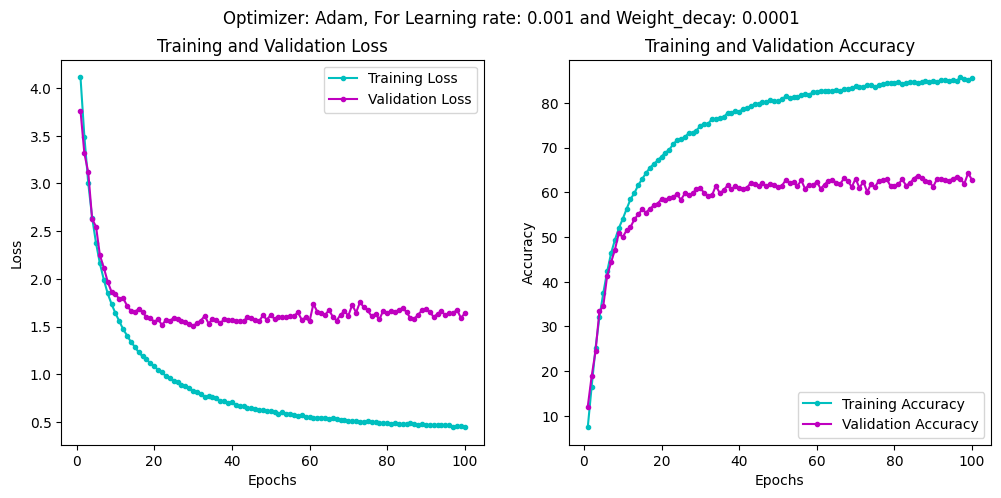

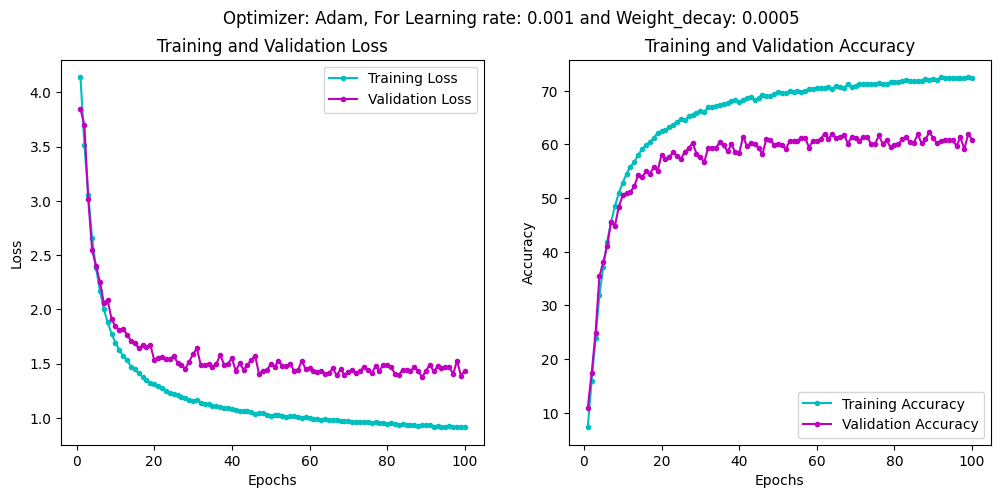

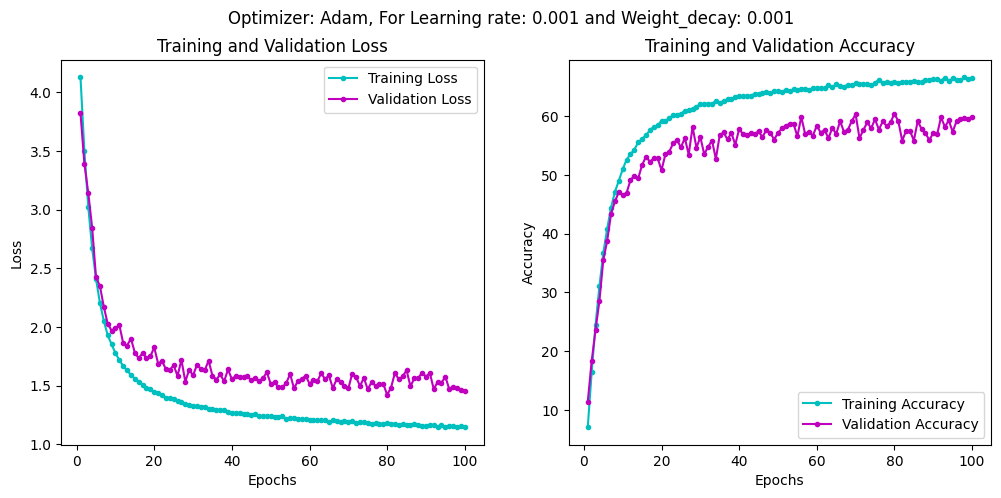

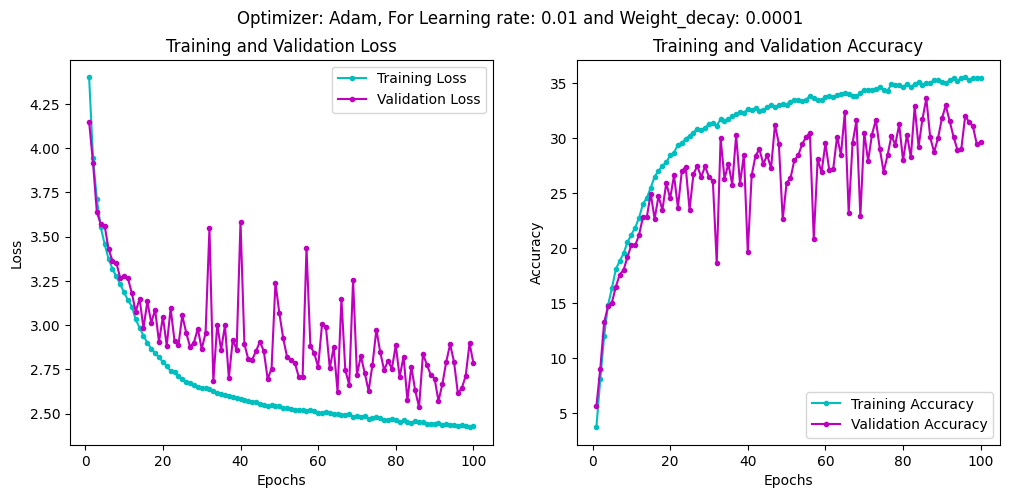

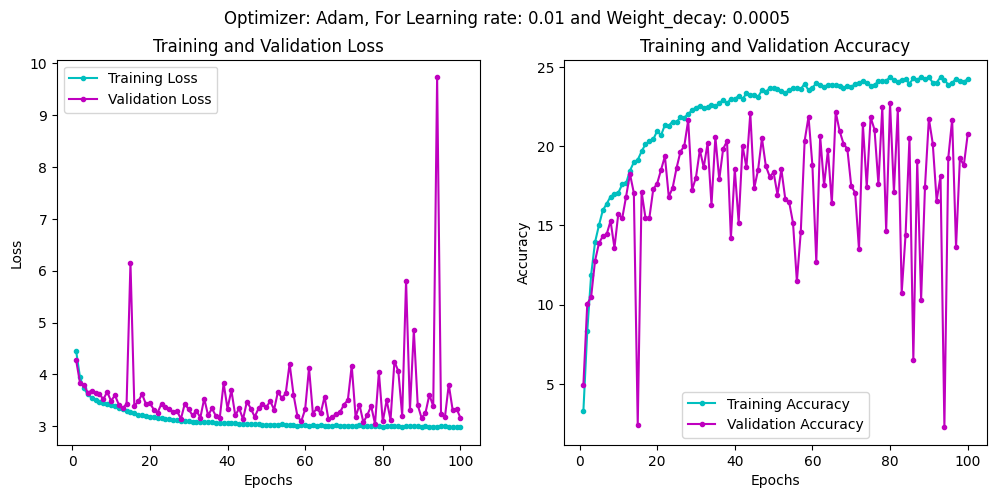

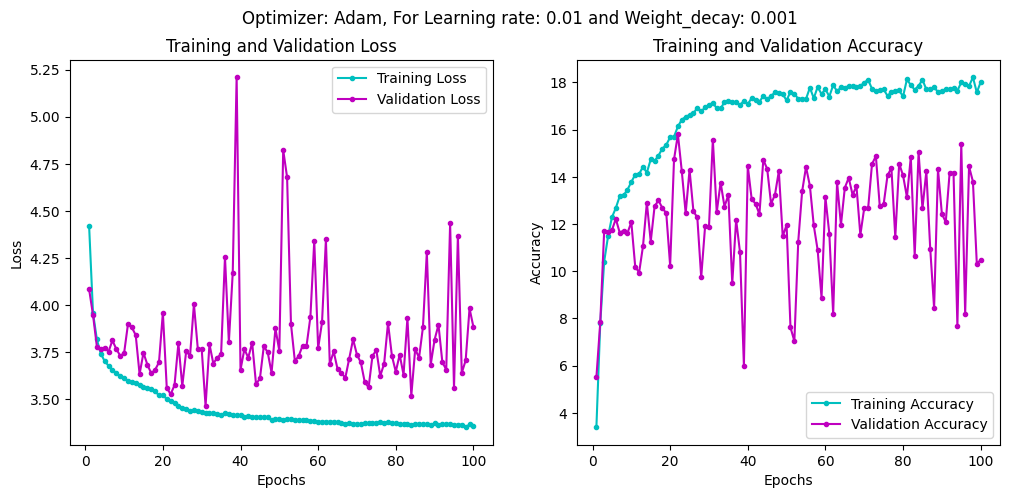

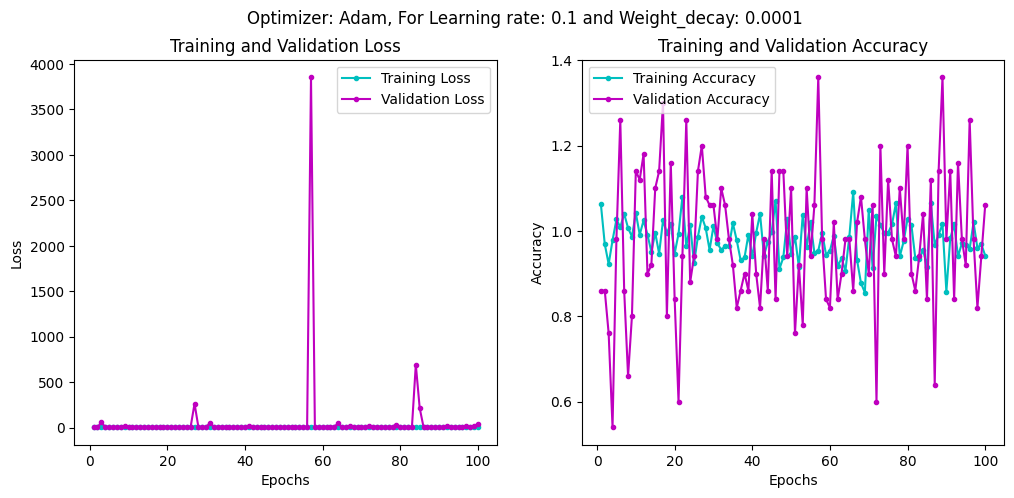

In [75]:
elements_per_plot = 100
lr_wd = [(0.001, 1e-4), (0.001, 5e-4), (0.001, 1e-3),(0.01, 1e-4), (0.01, 5e-4), (0.01, 1e-3), (0.1, 1e-4), (0.1, 5e-4), (0.1, 1e-3)]
wd = [1e-4, 5e-4, 1e-3]

num_plots = 7

for i in range(num_plots):
    start_idx = i * elements_per_plot
    end_idx = start_idx + elements_per_plot
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Optimizer: Adam, For Learning rate: {lr_wd[i][0]} and Weight_decay: {lr_wd[i][1]}')
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'][start_idx:end_idx], 'c.-', label='Training Loss')
    plt.plot(epochs, history['val_loss'][start_idx:end_idx], 'm.-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'][start_idx:end_idx], 'c.-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'][start_idx:end_idx], 'm.-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

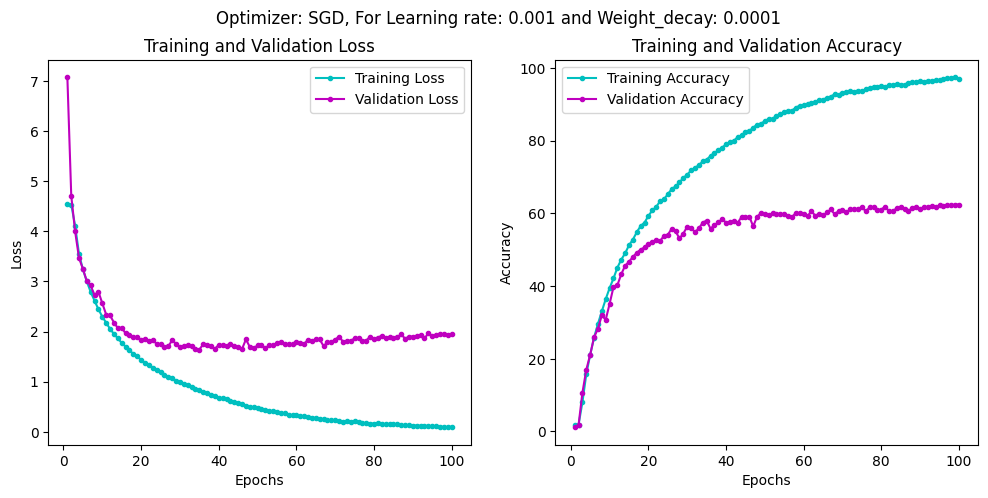

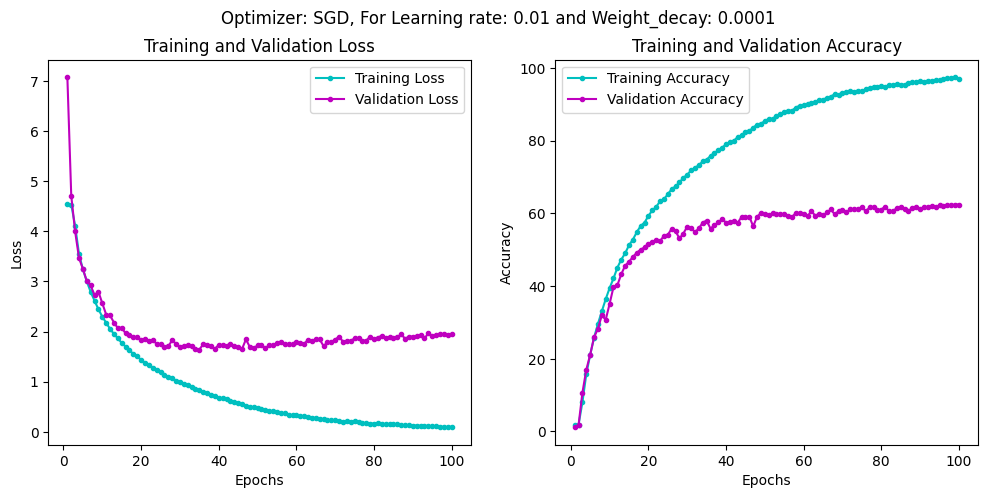

In [80]:
elements_per_plot = 100
lr_wd = [(0.001, 1e-4), (0.01, 1e-4)]
wd = [1e-4, 5e-4, 1e-3]

num_plots = 2

for i in range(num_plots):
    start_idx = 772
    end_idx = start_idx + elements_per_plot
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(f'Optimizer: SGD, For Learning rate: {lr_wd[i][0]} and Weight_decay: {lr_wd[i][1]}')
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'][start_idx:end_idx], 'c.-', label='Training Loss')
    plt.plot(epochs, history['val_loss'][start_idx:end_idx], 'm.-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'][start_idx:end_idx], 'c.-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'][start_idx:end_idx], 'm.-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

    start_idx = end_idx

In [79]:
from torchsummary import summary

model_summary = MyResNet()

summary(model_summary, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
             ReLU-10           [-1, 32, 32, 32]               0
       BasicBlock-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
             ReLU-14           [-1, 32,

In [81]:
def get_output_sizes(model, input_size=(3, 32, 32)):
    x = torch.rand(1, *input_size).to(DEVICE)  # Generate a random input tensor with the shape of a CIFAR-100 image
    sizes = []
    for layer in [model.conv1, model.conv2_x, model.conv3_x, model.conv4_x, model.conv5_x]:
        x = layer(x)
        sizes.append(x.size())  # Store the output size after each convX layer
    return sizes

In [82]:
output = get_output_sizes(MyResNet())
print(output)

AttributeError: 'ResNetCustom' object has no attribute 'conv2_x'